# Spaceship Titanic
_**Predict which passengers are transported to an alternate dimension**_

## Table of Content

1. [Importing Libraries and Data](#import)
2. [Exploratory Data Analysis](#import)
    - [Group ID from PassengerID](#Group)
    - [Homeplanet](#Homeplanet)
    - [CryoSleep](#CryoSleep)
    - [Deck from Cabin](#Deck)
    - [CabinNumber from Cabin](#Cabin)
    - [Side from Cabin](#Side)
    - [Destination](#Destination)
    - [Age](#Age)
    - [Vip](#Vip)
    - [Total Luxary Cost](#totalCost)
3. [Handling Missing Values](#missing-values)
4. [Final Feature Selection](#Feature)
5. [Pipeline](#pipeline)
6. [Model Fitting and Prediction](#fitting)

<a id='import'></a>
## Importing Libraries and Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
X_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
X_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
print(X_train.shape, X_test.shape)

(8693, 14) (4277, 13)


<a id='Explore'></a>
## Exploratory Data Analysis

In [3]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
def CrossTabPlot(featureName): 
    crossTabResult = pd.crosstab(index=X_train[featureName],columns=X_train['Transported'])
    print(crossTabResult)
    crossTabResult.plot.bar()
    

In [6]:
def HistPlot(featureName):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    sns.histplot(data = X_train, x=featureName, ax=ax1, bins=25, hue='Transported', kde=True)
    plt.show()

<a id="Group"></a>
### Group ID from PassengerID

Since family members are mostly in same group. So, Transportation rate of a group from training data might indicate Transportation likelyhood for another person from test data of that group

In [7]:
#Extracting Group Id from PassengerId
X_train['Group'] = X_train['PassengerId'].str.split('_',expand=True)[0]
X_test['Group'] = X_test['PassengerId'].str.split('_',expand=True)[0]

#finding groupwise transportation rate and mapping it to group
groupwise_transportation_rate = X_train[['Group','Transported']].groupby('Group').sum() / X_train[['Group','Transported']].groupby('Group').count()
groupwise_transportation_rate = groupwise_transportation_rate['Transported'].to_dict()
X_train['Group'] = X_train['Group'].map(groupwise_transportation_rate)
X_test['Group'] = X_test['Group'].map(groupwise_transportation_rate)

In [8]:
X_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,NaN
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,NaN
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,NaN
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,NaN


In [9]:
print(X_test['Group'].isna().sum())

4277


**conclusion:**

All the group_id in test data are new. So, training the model from `GroupID` would not be a good choice. 

In [10]:
X_train.drop('Group',axis=1, inplace= True)
X_test.drop('Group', axis=1, inplace= True)

<a id="Homeplanet"> </a>
### Homeplanet

Transported  False  True
HomePlanet              
Earth         2651  1951
Europa         727  1404
Mars           839   920


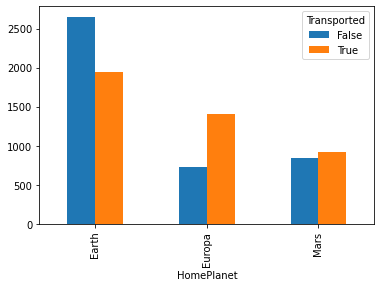

In [11]:
CrossTabPlot('HomePlanet')

**Conclusion:**
People in Earth is less likely to transport. 
Europa's people is more likely to transport and Marsians are neutral about transporting 

So, this feature sould be included while model building. 

<a id="CryoSleep"> </a>
### CryoSleep

Transported  False  True
CryoSleep               
False         3650  1789
True           554  2483


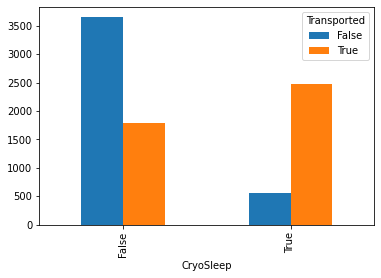

In [12]:
CrossTabPlot('CryoSleep')

**Conclusion:**
People who 
took CryoSleep has a significant chance of transportation. 
So, this feature sould be included while model building. 

<a id='Deck'></a>
### Exploring Deck from Cabin

Transported  False  True
Deck                    
A              129   127
B              207   572
C              239   508
D              271   207
E              563   313
F             1565  1229
G             1238  1321
T                4     1


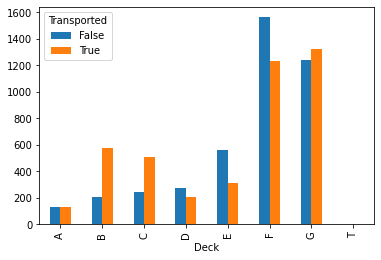

In [13]:
X_train['Deck'] = X_train['Cabin'].str.split('/',expand=True)[0]
X_test['Deck'] = X_test['Cabin'].str.split('/',expand=True)[0]
X_train['Deck'].unique()
CrossTabPlot('Deck')

**Conclusion:**

People from Deck 'B' and 'C' are more likely to get Transported. So feature 'Deck' should be included in the model.  

<a id='Cabin'></a>
### Exploring CabinNumber from Cabin

In [14]:
X_train['CabinNumber'] = X_train['Cabin'].str.split('/',expand=True)[1]
X_test['CabinNumber'] = X_test['Cabin'].str.split('/',expand=True)[1]
X_train['CabinNumber'].unique()

array(['0', '1', '2', ..., '1892', '1893', '1894'], dtype=object)

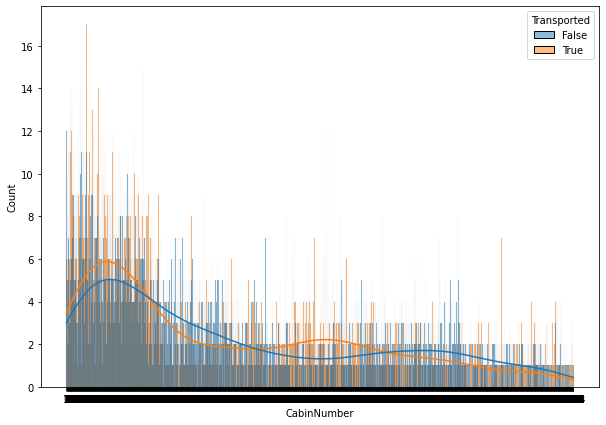

In [15]:
HistPlot('CabinNumber')

**Conclusion:**
The transporter distribution and the non-transporter distribution is quite similar. So, it should not be a feature in the model.  

In [16]:
#dropping column
X_train.drop('CabinNumber',axis=1, inplace= True)
X_test.drop('CabinNumber', axis=1, inplace= True)

<a id="Side"></a>
### Exploring Side from Cabin

Transported  False  True
Side                    
P             2308  1898
S             1908  2380


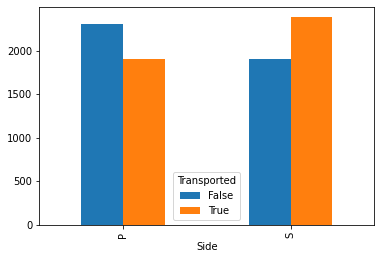

In [17]:
X_train['Side'] = X_train['Cabin'].str.split('/',expand=True)[2]
X_test['Side'] = X_test['Cabin'].str.split('/',expand=True)[2]

CrossTabPlot('Side')

**Conlusion:** People from `Starboard` side has a more chance of transporting than `Port` side. So, Side should be included as a feature. 

In [18]:
#dropping Cabin
X_train.drop('Cabin',axis=1, inplace= True)
X_test.drop('Cabin', axis=1, inplace= True)

<a id='Destination'></a>
### Exploring Destination

Transported    False  True
Destination               
55 Cancri e      702  1098
PSO J318.5-22    395   401
TRAPPIST-1e     3128  2787


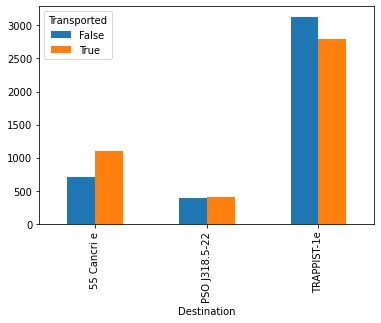

In [19]:
CrossTabPlot('Destination')

Destination should be included as a feature

<a id='Age'></a>
### Exploring Age

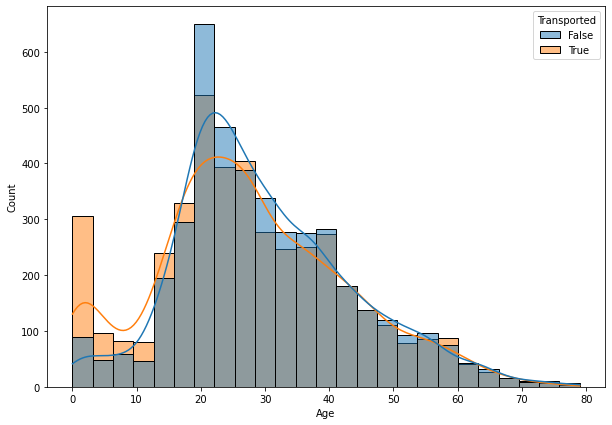

In [20]:
HistPlot('Age')

Children are more likely to transport. Although After 40, age is not a good indicator to predict Transportation. 
Still we are keeping age for now. 

In [21]:
X_train.loc[X_train['Age']<17, 'isChild'] = True
X_train['isChild'].fillna(False, inplace = True)

X_test.loc[X_train['Age']<17, 'isChild'] = True
X_test['isChild'].fillna(False, inplace = True)

<a id='Vip'></a>
### Exploring Vip Service

Transported  False  True
VIP                     
False         4093  4198
True           123    76


<AxesSubplot:xlabel='VIP'>

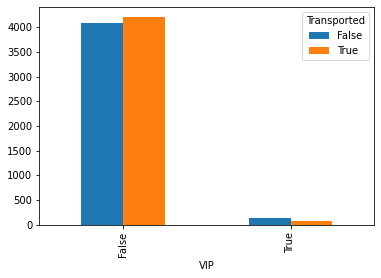

In [22]:
crossTabResult = pd.crosstab(index=X_train['VIP'],columns=X_train['Transported'])
print(crossTabResult)
crossTabResult.plot.bar()

**Conclusion:** People without VIP services were more likely to transport than people taking VIP services. So, keeping it as a feature. 

<a id='totalCost'> </a>
### Total Luxary Cost

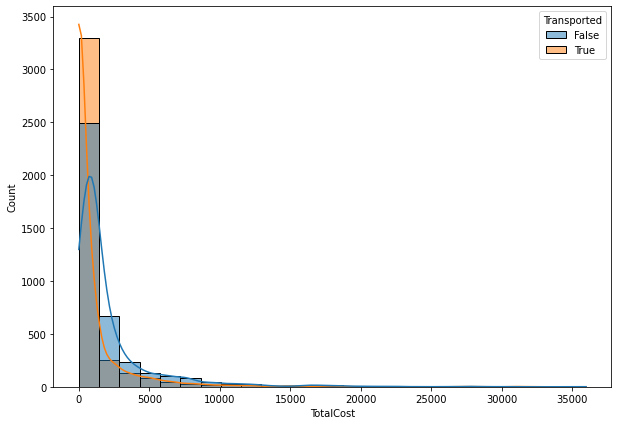

In [23]:
X_train['TotalCost'] = X_train['RoomService']+X_train['FoodCourt']+X_train['ShoppingMall']+X_train['Spa']+X_train['VRDeck']
X_test['TotalCost'] = X_test['RoomService']+X_test['FoodCourt']+X_test['ShoppingMall']+X_test['Spa']+X_test['VRDeck']
HistPlot('TotalCost')

People with less luxary cost are more likely to transport. So we will keep each individual cost and also totalCost

<a id='missing-values'></a>
## Handling Missing values

In [24]:
print(X_train.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Side            199
isChild           0
TotalCost       908
dtype: int64


In [25]:
X_train.loc[(X_train['CryoSleep']==True) & (X_train['TotalCost']>0)] 

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,isChild,TotalCost


People in cryosleep were unable to avail Room service, food court and other services. So, we are going to fill some missing values using that information. 

In [26]:
# set the missing values of luxary costs 0, where CryoSleep is true. 
for column in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['CryoSleep']==True,0,np.NaN)))
    X_test[column] = X_test[column].fillna(pd.Series(np.where(X_test['CryoSleep']==True,0,np.NaN)))

In [27]:
X_train['TotalCost'] = X_train['RoomService']+X_train['FoodCourt']+X_train['ShoppingMall']+X_train['Spa']+X_train['VRDeck']
X_test['TotalCost'] = X_test['RoomService']+X_test['FoodCourt']+X_test['ShoppingMall']+X_test['Spa']+X_test['VRDeck']

In [28]:
print(X_train.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name            200
Transported       0
Deck            199
Side            199
isChild           0
TotalCost       561
dtype: int64


<a id='Feature'></a>
### Final Feature Selection

In [29]:
features = ['HomePlanet','CryoSleep','Deck','Side','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalCost']
features.append('isChild') # dropped 'Age',
y = X_train.Transported
X_train = X_train[features]

<a id='pipeline'></a>
### Pipeline

In [30]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)


numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)


cat_cols = X_train.select_dtypes(exclude="number").columns
num_cols = X_train.select_dtypes(include="number").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

<a id='eval'> </a>
### Model Evaluation

In [31]:
def evaluateModel(model):
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)]) 
    scores = cross_val_score(my_pipeline, X_train, y,cv=5,scoring='accuracy')
    return scores

In [32]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
models = {}
models['XGB'] = XGBClassifier(random_state = 0)
models['RF'] = RandomForestClassifier(random_state=0)
models['ADA'] = AdaBoostClassifier(random_state=0)
models['LR'] = LogisticRegression(random_state=0)
models['LGBM'] = LGBMClassifier(random_state=0)
models['SGDC'] = SGDClassifier(random_state=0)

model_scores = []
model_names = []

for model_name in models.keys():
    model_names.append(model_name)
    model_scores.append(evaluateModel(models[model_name]))

In [33]:
for model_name, model_score in zip(model_names, model_scores):
    print(model_name, '\t: ',model_score.mean(), '\t ', model_score.std())

XGB 	:  0.7978853765010512 	  0.009559518112192923
RF 	:  0.795815419758323 	  0.015166608405463302
ADA 	:  0.7878767144589929 	  0.010150626095136003
LR 	:  0.7884514928953388 	  0.010954893373305243
LGBM 	:  0.7991515963236944 	  0.013890485311378582
SGDC 	:  0.789143596011358 	  0.015059854786790412


[]

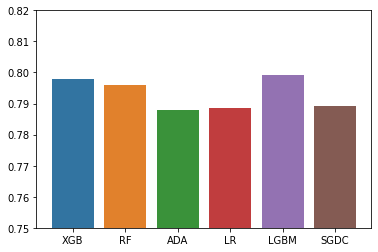

In [34]:
# sns.color_palette("Paired")
plt.ylim(0.75, 0.82)
ax = sns.barplot(data=model_scores, ci= None)
ax.set_xticklabels(model_names)
plt.plot()

<a id='fitting'></a>
### Model Fitting and Prediction

In [35]:
from sklearn.ensemble import VotingClassifier
estimators = [('XGB',XGBClassifier(random_state = 0)), ('LGBM',LGBMClassifier(random_state=0)),
              ('RF',RandomForestClassifier(random_state=0))]

In [36]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('vr', VotingClassifier(estimators, voting ='soft'))]) 
my_pipeline.fit(X_train, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalCost'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh-encode',
                                                                   OneHotEncoder(h...


In [37]:
PassengerIds = X_test['PassengerId']
X_test = X_test[features]

In [38]:
#submission 
preds_test = my_pipeline.predict(X_test) 
preds_test_str = []
for i in range(len(preds_test)):
    if preds_test[i] == 0:
        preds_test_str.append('False')
    else:
        preds_test_str.append('True')
# Save test predictions to file
output = pd.DataFrame({'PassengerId': PassengerIds,'Transported': preds_test_str})
output.to_csv('submission.csv', index=False)

In [39]:
output

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
